# Implementation of some of concepts from Adapting Auxiliary Losses Using Gradient Similarity 

## Import neccessary python libraries

In [1]:
import matplotlib.pyplot as plt # plotting and data visualization
import numpy as np # numerical operations
from sklearn.metrics.pairwise import cosine_similarity
import tensorflow as tf # ML framework of choice

# Pretty new capability to compute in fly - simillar to pytorch/numpy, with little performance drop
tf.enable_eager_execution() 

## Figure 7: Illustration of cosine similarity between gradients on synthetic loss surfaces.

Helper functions

In [2]:
def plot_gradients(x0, y0, dx, dy, ax, color):
    """Plots gradients of given points and steps with arrows"""
    if dy>0:
        dy = -dy
        dx = -dx
    ax.quiver(x0, y0, dx, dy, color=color, angles='xy', scale=1, width = 0.01) #plot arrows on given arrow
    
main = lambda x: (x - 10)**2 # calculates main function value
aux = lambda x: x**2 # calculates aux function value

def prep_plot(ax, x_lim, y_lim):
    """ Prepares plot, to not repeat same procedure twice and make code a bit tidyier."""
    
    ax.set_xlim(*x_lim) # limit xaxis
    ax.set_ylim(*y_lim) # limit yaxis
    
    # Disable x,y axis ticks (as in paper)
    ax.xaxis.set_ticks_position('none') # remove xticks - as in paper
    ax.yaxis.set_ticks_position('none') # remove yticks - as in paper

    # Plot Vertical lines 
    ax.axvline(x=-20, linestyle='--', color='g', linewidth = 2.0) # plot first starting point vertical line
    ax.axvline(x=5, linestyle='--', color='y', linewidth = 2.0) # plot second starting point vertical line

Let's recreate these figures.

Text(0.5, 0, '$\\theta$')

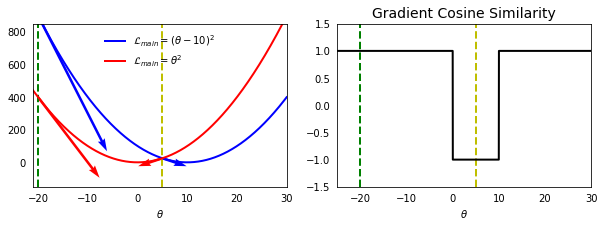

In [3]:
dx = 0.01 # set step for parameter theta <- should be enough to make it look nice

fig = plt.figure(figsize=(10, 3)) #create figure with specific size

# First subplot
ax1 = fig.add_subplot(121)

# Prepare axis
prep_plot(ax1, (-21,30), (-150, 850))

x = np.arange(-25,30, dx) # create vector with theta values
y_main = main(x) # calculate main function value
y_aux = aux(x) # calculate auxiliary function value
main_grad = np.gradient(y_main) # calculate main function value
aux_grad = np.gradient(y_aux) # calculate main function value

ax1.plot(x, y_main, linewidth = 2.0, color = 'b', label=r'$\mathcal{L}_{main} = (\theta-10)^2$')
ax1.plot(x, y_aux, linewidth = 2.0, color = 'r', label=r'$\mathcal{L}_{main} = \theta^2$')

plot_gradients(-20, y_main[np.isclose(x,-20)], dx, main_grad[np.isclose(x,-20)], ax1, color = 'b')
plot_gradients(-20, y_aux[np.isclose(x,-20)], dx, aux_grad[np.isclose(x,-20)], ax1, color = 'r')

plot_gradients(5, y_main[np.isclose(x,5)], dx, main_grad[np.isclose(x,5)], ax1, color = 'b')
plot_gradients(5, y_aux[np.isclose(x,5)], dx, aux_grad[np.isclose(x,5)], ax1, color = 'r')

plt.xlabel(r'$\theta$')
ax1.legend(frameon=False) # Show legend - as in paper.

# Second subplot
ax2 = fig.add_subplot(122)

# Calculate gradient of cosine similarity with specified parameter range
cos_sim = cosine_similarity(main_grad.reshape(-1, 1), \
                            aux_grad.reshape(-1, 1))[np.where(np.eye(len(main_grad)))]

# Prepare axis
prep_plot(ax2, (-25,30), (-1.5, 1.5))

# Plot Gradient Cosine Similarity
ax2.plot(x, cos_sim, linewidth = 2.0, color = 'black')

plt.title("Gradient Cosine Similarity", size = 14)
plt.xlabel(r'$\theta$')

## Algorithm 1

### Algorithm implementation using CNN toy model with training on MNIST dataset
* main task: binary classification of numbers: 1 vs 2
* auxiliary task: binary classification of numbers: 3 vs 4
* 2 shared CNN layers
* 2 Dense specific layers (1 hidden and last for final classification)

Load mnist data

In [4]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

Rescale images to (0,1)

In [5]:
x_train, x_test = x_train / 255.0, x_test / 255.0

Add channel axis

In [6]:
x_train, x_test = np.expand_dims(x_train,-1), np.expand_dims(x_test,-1)

Find task specific samples' indices

In [7]:
which_main_train = [x in [1,2] for x in y_train]
which_main_test = [x in [1,2] for x in y_test]
which_aux_train = [x in [3,4] for x in y_train]

Select only samples which are needed for main and aux tasks

In [8]:
y_train_main = y_train[which_main_train]
y_test_main = y_test[which_main_test]
y_train_aux = y_train[which_aux_train]

Transform labels to [0,1]

In [9]:
y_train_main = (y_train_main==y_train_main.max()).astype('int')
y_test_main = (y_test_main==y_test_main.max()).astype('int')
y_train_aux = (y_train_aux==y_train_main.max()).astype('int')

Create Dataset object for easy data manipulations

In [10]:
train_ds_main = tf.data.Dataset.from_tensor_slices((x_train[which_main_train], y_train_main))
train_ds_main = train_ds_main.map(lambda x, y: (tf.to_float(x), tf.one_hot(y, 2))).shuffle(1000)
test_ds_main = tf.data.Dataset.from_tensor_slices((x_test[which_main_test], y_test_main))
test_ds_main = test_ds_main.map(lambda x, y: (tf.to_float(x), tf.one_hot(y, 2))).shuffle(1000)
train_ds_aux = tf.data.Dataset.from_tensor_slices((x_train[which_aux_train], y_train_aux))
train_ds_aux = train_ds_aux.map(lambda x, y: (tf.to_float(x), tf.one_hot(y, 2))).shuffle(1000)

Define few helper functions

In [11]:
def loss_fn(y_true, y_pred):
    """Computes loss function using softmax activation function and categorical cross entropy.
    """

    return tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits_v2(
          logits=y_pred, labels=y_true))

def get_avg_acc_loss(dataset, model):
    """Helper function for measuring average loss and accurancy of model.
    """

    def get_accuracy(y_true, y_pred):
        y_pred = tf.argmax(y_pred, 1)
        equality = tf.equal(y_pred, tf.argmax(y_true, 1))
        accuracy = tf.reduce_mean(tf.cast(equality, tf.float32))
        return accuracy
    
    avg_acc = tf.Variable(0,dtype=tf.float32)
    avg_loss = tf.Variable(0,dtype=tf.float32)
    for (batch, (images, labels)) in enumerate(dataset.batch(500, drop_remainder=True)):
        avg_acc = tf.math.add(avg_acc,get_accuracy(labels, model(images)))
        avg_loss = tf.math.add(avg_loss,loss_fn(labels, model(images)))
    
    return avg_acc/(batch+1), avg_loss/(batch+1)

def get_models(input_shape = x_train.shape[1:]):
    """Returns very simple CNN tf.keras.Model instance with N-1 shared layers for both tasks and single task-specific layer.
    """

    inp = tf.keras.layers.Input(shape = input_shape)
    x = tf.keras.layers.Conv2D(32, 3,padding='same',activation='relu')(inp)
    x = tf.keras.layers.MaxPooling2D((2, 2), (2, 2), padding='same')(x)
    x = tf.keras.layers.Conv2D(64, 3,padding='same',activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D((2, 2), (2, 2), padding='same')(x)
    x = tf.keras.layers.Flatten()(x)

    main = tf.keras.layers.Dense(128, activation='relu')(x)
    aux = tf.keras.layers.Dense(128, activation='relu')(x)
    main = tf.keras.layers.Dense(2)(main)
    aux = tf.keras.layers.Dense(2)(aux)

    return (tf.keras.Model(inputs = inp, outputs = main), tf.keras.Model(inputs = inp, outputs = aux))

def get_grad_cos_sim(grad1, grad2, sep_ind):
    """Computes cos simillarity of gradients after flattening of tensors.
    """
    grad1 = tf.concat([tf.reshape(x,shape=(-1,)) for x in grad1[:sep_ind]], axis = 0)
    grad2 = tf.concat([tf.reshape(x,shape=(-1,)) for x in grad2[:sep_ind]], axis = 0)
    return 1 - tf.losses.cosine_distance(grad1,grad2,axis = 0)

#### Test algorythm by training

In [12]:
model_main, model_aux = get_models()

optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01)

epochs = 10 # number of epochs
steps = 100 # numbers of steps per epoch
priv_layers = 2 # defines how much layers are task specific
priv_ind = -2 * priv_layers # task specific layers are usually last and they by default come with bias - another variable

# Main training loop
for epoch in range(epochs):
    combined_updates = 0
    # Iterate over both main and aux task training samples
    for (batch, ((images_main, labels_main), (images_aux, labels_aux))) in enumerate(
        zip(train_ds_main.batch(1), train_ds_aux.batch(1))):

        # Break if we already did enough steps
        if batch == steps:
            break

        # Compute losses
        with tf.GradientTape() as tape_main:
            loss_main = loss_fn(labels_main, model_main(images_main))

        with tf.GradientTape() as tape_aux:
            loss_aux = loss_fn(labels_aux, model_aux(images_aux))

        # 3: compute gradients for shared and private parameters of both tasks
        grads_main = tape_main.gradient(loss_main, model_main.variables)
        grads_aux = tape_aux.gradient(loss_aux, model_aux.variables)

        # 4: update private parameters
        optimizer.apply_gradients(
            zip(
                grads_main[priv_ind:], 
                model_main.variables[priv_ind:]))
                
        optimizer.apply_gradients(
            zip(
                grads_aux[priv_ind:], 
                model_aux.variables[priv_ind:]))

        # 5+: compute cosine similarity for shared gradients of both tasks and decide how to update shared parameters
        # Upgrading only main model will case aux model to update at the same time - they share layers and weights
        if get_grad_cos_sim(grads_main, grads_aux, priv_ind)>=0:
            grad_sum = [x1+x2 for (x1, x2) in zip(grads_main[:priv_ind],grads_aux[:priv_ind])]
            optimizer.apply_gradients(
                zip(
                    grad_sum, 
                    model_main.variables[:priv_ind]))
            combined_updates+=1
        else:
            optimizer.apply_gradients(
                zip(
                    grads_main[:priv_ind], 
                    model_main.variables[:priv_ind]))

    # Compute average loss and accurancy for both training and test subset of main task samples
    avg_acc, avg_loss = get_avg_acc_loss(train_ds_main, model_main)
    test_avg_acc, test_avg_loss = get_avg_acc_loss(test_ds_main, model_main)
    
    # Print stats
    print("Epoch:{} | loss={:.3f} acc={:.2f}% | val_loss={:.3f} val_acc={:.2f}% | comb_up={:.1f}%".\
    format(epoch+1, avg_loss.numpy(), avg_acc.numpy()*100,test_avg_loss.numpy(), test_avg_acc.numpy()*100, combined_updates/steps*100))

Epoch:1 | loss=0.157 acc=96.70% | val_loss=0.159 val_acc=96.95% | comb_up=71.0%
Epoch:2 | loss=0.083 acc=97.74% | val_loss=0.076 val_acc=98.40% | comb_up=90.0%
Epoch:3 | loss=0.052 acc=98.61% | val_loss=0.042 val_acc=99.30% | comb_up=99.0%
Epoch:4 | loss=0.044 acc=98.73% | val_loss=0.032 val_acc=99.25% | comb_up=97.0%
Epoch:5 | loss=0.046 acc=98.46% | val_loss=0.035 val_acc=99.00% | comb_up=99.0%
Epoch:6 | loss=0.044 acc=98.54% | val_loss=0.030 val_acc=99.20% | comb_up=100.0%
Epoch:7 | loss=0.050 acc=98.78% | val_loss=0.040 val_acc=99.35% | comb_up=97.0%
Epoch:8 | loss=0.042 acc=98.68% | val_loss=0.029 val_acc=99.40% | comb_up=99.0%
Epoch:9 | loss=0.044 acc=98.74% | val_loss=0.033 val_acc=99.35% | comb_up=97.0%
Epoch:10 | loss=0.040 acc=98.86% | val_loss=0.030 val_acc=99.40% | comb_up=97.0%
